## Import des librairies

In [ ]:
import pandas as pd
import numpy as np
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


## Chargement et Exploration des données

In [ ]:
# recherche du type d'encodage
with open("spam.csv", "rb") as f:
    result = chardet.detect(f.read())
    print(result)

{'encoding': 'Windows-1252', 'confidence': 0.7269493857068697, 'language': ''}


In [ ]:
df = pd.read_csv("spam.csv", encoding="Windows-1252")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# taille du dataset
df.shape

(5572, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
df.describe(include="all")

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


### Analyse des valeurs manquantes

In [ ]:
# Nombre de valeurs manquantes
df.isna().sum()

,0
v1,0
v2,0
Unnamed: 2,5522
Unnamed: 3,5560
Unnamed: 4,5566


In [ ]:
# Pourcentage des valeurs manquantes
100 * df.isnull().sum() / df.shape[0]
#.sort_values(ascending=False)


,0
v1,0.000000
v2,0.000000
Unnamed: 2,99.102656
Unnamed: 3,99.784637
Unnamed: 4,99.892319


<Axes: >

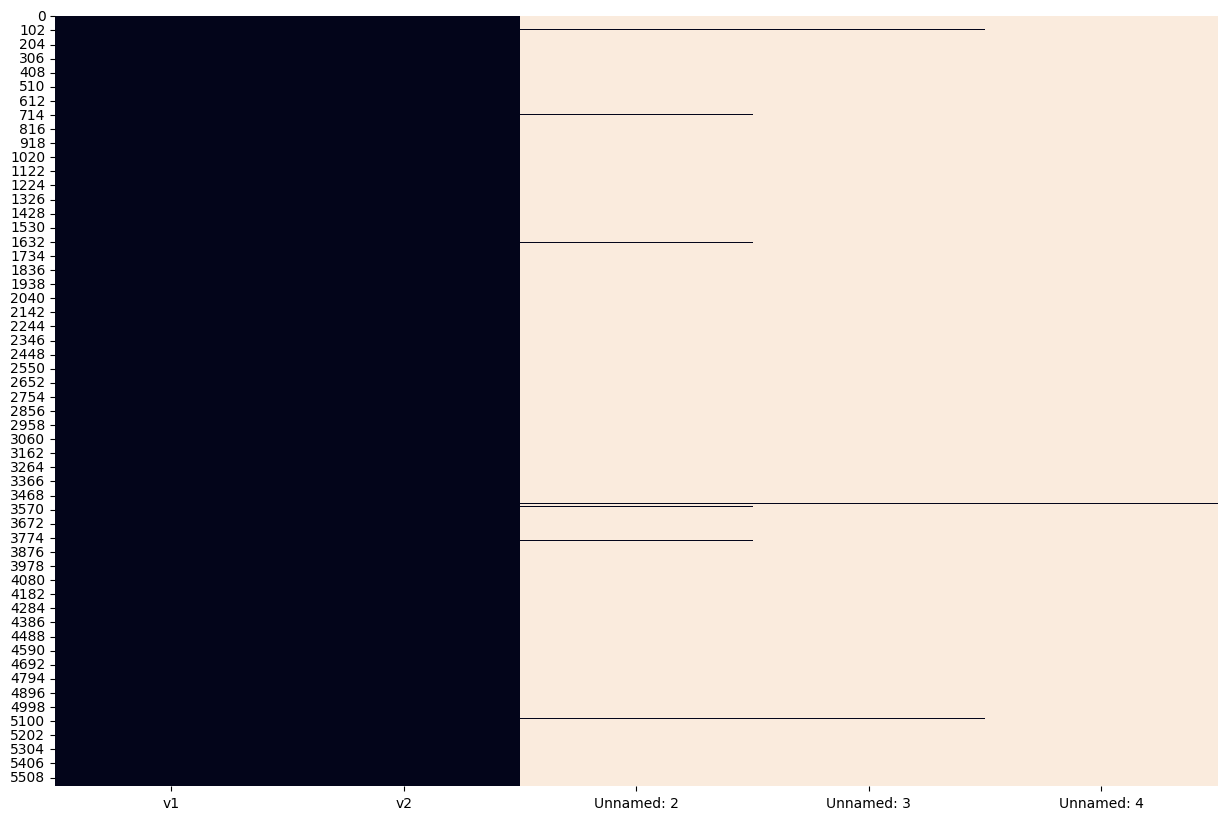

In [ ]:
# Visualisation des données manquantes
plt.figure(figsize=(15,10))
sns.heatmap(df.isna(), cbar=False)

Il semble que les colonnes 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4' complètent la colonne 'v2'

In [ ]:
df['sms'] = df[['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']].apply(
    lambda row: ' '.join(str(message) for message in row if pd.notna(message) ), axis=1)

In [ ]:
df = df[['v1', 'sms']]

In [ ]:
df.head()

,v1,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Analyse des doublons

In [ ]:
df.duplicated().sum()

np.int64(403)

In [ ]:
# Suppression des doublons
df = df.drop_duplicates(keep="first")

In [ ]:
df.shape

(5169, 2)

### Analyse de la variable cible : v1

In [ ]:
df['v1'].value_counts()

,count
v1,
ham,4516
spam,653


In [ ]:
df['v1'].value_counts(normalize=True)

,proportion
v1,
ham,0.87367
spam,0.12633


### Etude de la taille des messages

In [ ]:
df['len_sms'] = df['sms'].apply(lambda x: len(x.split()))
df.head()

,v1,sms,len_sms
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [ ]:
fig = px.box(df,
             y='len_sms',
             color='v1',
             title="Distribution de la longueur des SMS ('ham' vs 'spam')",
             labels={'v1': 'Type de message', 'len_sms': 'Longueur du SMS'},
             width=800,
             height=500)
fig.show()

In [ ]:
# suppression des sms dont la longueur est supérieure à 37
df = df[df["len_sms"]<=37]

In [ ]:
df['v1'].value_counts(normalize=True)

,proportion
v1,
ham,0.870667
spam,0.129333


In [ ]:
df.shape

(5049, 3)

---

## Preprocessing

In [ ]:
# Convertion des labels en valeurs numériques (spam=1, ham=0)
df["label"] = df["v1"].map({"ham": 0, "spam": 1})

### Nettoyage du corpus

In [ ]:
# Conversion en minuscules, suppression des caractères non alphabétiques et nettoyage des espaces multiples
df.loc[:,'clean_sms'] = df['sms'].str.lower()\
                          .str.replace(r'[^a-zA-Z\s]', ' ', regex=True)\
                          .str.replace(r'\s+', ' ', regex=True)\
                          .str.strip()

df.head()

,v1,sms,len_sms,label,clean_sms
0,ham,"Go until jurong point, crazy.. Available only ...",20,0,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,1,free entry in a wkly comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,11,0,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,0,nah i don t think he goes to usf he lives arou...


In [ ]:
data = df.copy()

Lemmatisation et STOP_WORDS

In [ ]:
# Chargement du modèle Spacy de langue anglaise
nlp = spacy.load("en_core_web_sm")

# Fonction de lemmatisation et suppression des stopwords
def lemmatize_text(text):
    doc = nlp(text)
    clean_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return clean_text

# Lemmatisation de la colonne 'clean_sms'
df['lemmatized_sms'] = df['clean_sms'].apply(lemmatize_text)

df.head()

,v1,sms,len_sms,label,clean_sms,lemmatized_sms
0,ham,"Go until jurong point, crazy.. Available only ...",20,0,go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,6,0,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,1,free entry in a wkly comp to win fa cup final ...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,11,0,u dun say so early hor u c already then say,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,0,nah i don t think he goes to usf he lives arou...,nah don t think go usf live


Effacer les sms vides

In [ ]:
# Nombre de chaînes vides dans la colonne 'lemmatized_sms'
print((df['lemmatized_sms'] == '').sum())

15


In [ ]:
# Suppression des lignes de chaines vides
df = df[df['lemmatized_sms'] != '']

In [ ]:
df.shape

(5034, 6)

In [ ]:
df.head()

,v1,sms,len_sms,label,clean_sms,lemmatized_sms
0,ham,"Go until jurong point, crazy.. Available only ...",20,0,go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,6,0,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,1,free entry in a wkly comp to win fa cup final ...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,11,0,u dun say so early hor u c already then say,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,0,nah i don t think he goes to usf he lives arou...,nah don t think go usf live


In [ ]:
df = df[['label', 'lemmatized_sms']]

In [ ]:
df.head()

,label,lemmatized_sms
0,0,jurong point crazy available bugis n great wor...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun early hor u c
4,0,nah don t think go usf live


In [ ]:
# Séparation des Features et Labels
X = df["lemmatized_sms"].values
y = df["label"].values


Séparation des données en ensemble d'entraînement, de test et de validation

In [ ]:
# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Encodage des sms en séquences numériques

In [ ]:
# Paramètres du Tokenizer
num_words = 1000  # Nombre de mots les plus fréquents à prendre en compte
max_len = max([len(seq) for seq in X]) # Longueur maximale des séquences

# initialisation du Tokeniser
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token="<OOV>")

# entrainement du Tokenizer sur l'ensemble de train
tokenizer.fit_on_texts(X_train)

In [ ]:
tokenizer.index_word

{1: '<OOV>',
 2: 'u',
 3: 's',
 4: 'm',
 5: 't',
 6: 'ur',
 7: 'not',
 8: 'come',
 9: 'get',
 10: 'go',
 11: 'good',
 12: 'free',
 13: 'ok',
 14: 'gt',
 15: 'lt',
 16: 'day',
 17: 'll',
 18: 'know',
 19: 'time',
 20: 'send',
 21: 'like',
 22: 'want',
 23: 'love',
 24: 'text',
 25: 'think',
 26: 'tell',
 27: 'need',
 28: 'lor',
 29: 'p',
 30: 'txt',
 31: 'stop',
 32: 'win',
 33: 'home',
 34: 'reply',
 35: 'k',
 36: 'da',
 37: 'r',
 38: 'today',
 39: 'mobile',
 40: 'don',
 41: 'n',
 42: 'new',
 43: 'hi',
 44: 'phone',
 45: 'c',
 46: 'miss',
 47: 'ask',
 48: 'night',
 49: 'sorry',
 50: 'hope',
 51: 'week',
 52: 'work',
 53: 'wait',
 54: 'hey',
 55: 'wat',
 56: 'meet',
 57: 'claim',
 58: 'oh',
 59: 'thank',
 60: 'e',
 61: 'try',
 62: 'message',
 63: 'later',
 64: 'msg',
 65: 'pls',
 66: 'say',
 67: 'number',
 68: 'dear',
 69: 'thing',
 70: 'd',
 71: 'leave',
 72: 'yes',
 73: 've',
 74: 'friend',
 75: 'www',
 76: 'min',
 77: 'yeah',
 78: 'great',
 79: 'find',
 80: 'late',
 81: 'tomorrow',
 

In [ ]:
# Transformation des textes en séquences numériques
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Remplissage (Padding) des séquences pour avoir la même longueur
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [ ]:
X_train_padded.shape

(4027, 193)

---

## Baseline

In [ ]:
# Modèle
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words+1, output_dim=32),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train_padded, y_train,
                    epochs=50,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stopping])

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8751 - loss: 0.4121 - val_accuracy: 0.8699 - val_loss: 0.3759
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8692 - loss: 0.3783 - val_accuracy: 0.8699 - val_loss: 0.3755
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8662 - loss: 0.3810 - val_accuracy: 0.8699 - val_loss: 0.3710
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8759 - loss: 0.3591 - val_accuracy: 0.8699 - val_loss: 0.3697
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8719 - loss: 0.3640 - val_accuracy: 0.8699 - val_loss: 0.3630
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8662 - loss: 0.3691 - val_accuracy: 0.8699 - val_loss: 0.3547
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8826 - loss: 0.3310 - val_accuracy: 0.8699 - val_loss: 0.3525
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8719 - loss: 0.3407 - val_accuracy: 

In [ ]:
# Architecture du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 193, 32)        │        32,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,733 (381.77 KB)

 Trainable params: 32,577 (127.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,156 (254.52 KB)

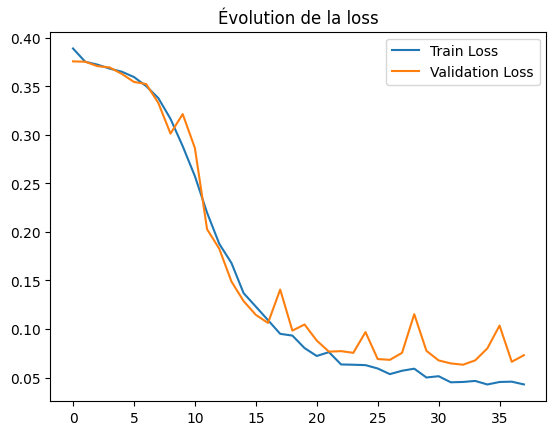

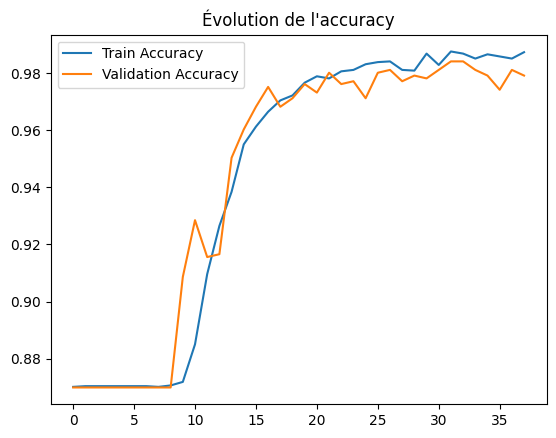

In [ ]:
# Visualisation de la perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Évolution de la loss')
plt.show()

# Visualisation de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Évolution de l\'accuracy')
plt.show()

In [ ]:
# Évaluation du modèle
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9841112214498511
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       876
           1       0.98      0.89      0.94       131

    accuracy                           0.98      1007
   macro avg       0.98      0.95      0.96      1007
weighted avg       0.98      0.98      0.98      1007



In [ ]:
# Matrice de confusion
confusion_matrix(y_test, y_pred)

array([[874,   2],
       [ 14, 117]])

## RNN

In [ ]:
# Modèle
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words + 1, output_dim=32),
    #tf.keras.layers.Bidirectional(tf.keras.layers.RNN(32)),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train_padded, y_train,
                    epochs=50,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stopping])

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.8649 - loss: 0.3767 - val_accuracy: 0.9782 - val_loss: 0.0881
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9772 - loss: 0.0803 - val_accuracy: 0.9782 - val_loss: 0.0855
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9905 - loss: 0.0459 - val_accuracy: 0.9831 - val_loss: 0.0732
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9911 - loss: 0.0364 - val_accuracy: 0.9821 - val_loss: 0.0770
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9920 - loss: 0.0310 - val_accuracy: 0.9821 - val_loss: 0.0812
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.9925 - loss: 0.0292 - val_accuracy: 0.9811 - val_loss: 0.0749
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9957 - loss: 0.0156 - val_accuracy: 0.9831 - val_loss: 0.0852
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9979 - loss: 0.0089 - v

In [ ]:
# Architecture du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 193, 32)        │        32,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,917 (448.90 KB)

 Trainable params: 38,305 (149.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,612 (299.27 KB)

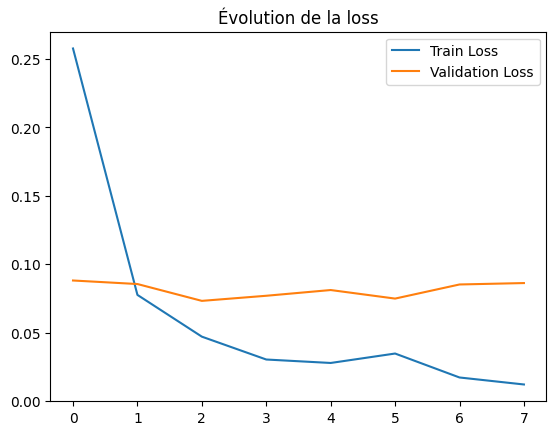

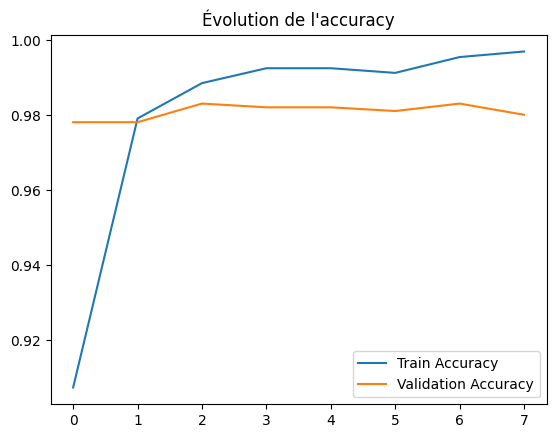

In [ ]:
# Visualisation de la perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Évolution de la loss')
plt.show()

# Visualisation de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Évolution de l\'accuracy')
plt.show()

In [ ]:
# Évaluation du modèle
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
print("Accuracy :", accuracy_score(y_test, y_pred))
print()
print('Classification report : ')
print(classification_report(y_test, y_pred))
print()
print('Matrice de confusion : ')
print(confusion_matrix(y_test, y_pred))


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Accuracy : 0.9831181727904668

Classification report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       876
           1       0.98      0.89      0.93       131

    accuracy                           0.98      1007
   macro avg       0.98      0.94      0.96      1007
weighted avg       0.98      0.98      0.98      1007


Matrice de confusion : 
[[874   2]
 [ 15 116]]


## LSTM

In [ ]:
# Modèle
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words + 1, output_dim=32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train_padded, y_train,
                    epochs=50,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stopping])


Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.8644 - loss: 0.4033 - val_accuracy: 0.9762 - val_loss: 0.1011
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.9817 - loss: 0.0765 - val_accuracy: 0.9782 - val_loss: 0.0711
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.9889 - loss: 0.0399 - val_accuracy: 0.9851 - val_loss: 0.0645
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.9913 - loss: 0.0292 - val_accuracy: 0.9841 - val_loss: 0.0669
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9926 - loss: 0.0274 - val_accuracy: 0.9841 - val_loss: 0.0733
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9931 - loss: 0.0245 - val_accuracy: 0.9791 - val_loss: 0.0825
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.9931 - loss: 0.0199 - val_accuracy: 0.9821 - val_loss: 0.0875
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9972 - loss: 0

In [ ]:
# Architecture du modèle
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 193, 32)        │        32,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,357 (595.15 KB)

 Trainable params: 50,785 (198.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,572 (396.77 KB)

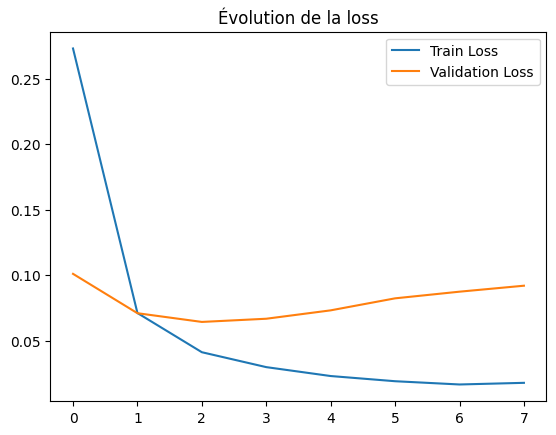

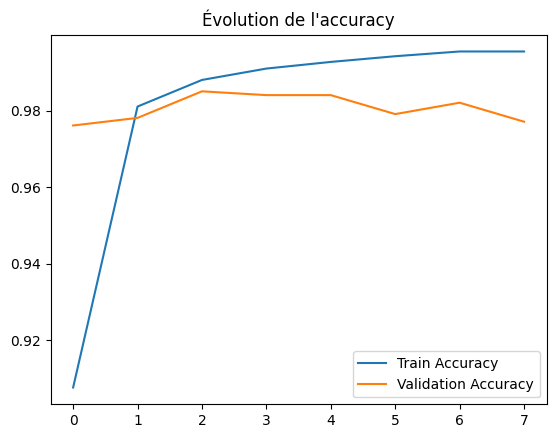

In [ ]:
# Visualisation de la perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Évolution de la loss')
plt.show()

# Visualisation de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Évolution de l\'accuracy')
plt.show()

In [ ]:
# Évaluation du modèle
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
print("Accuracy :", accuracy_score(y_test, y_pred))
print()
print('Classification report : ')
print(classification_report(y_test, y_pred))
print()
print('Matrice de confusion : ')
print(confusion_matrix(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Accuracy : 0.9851042701092354

Classification report : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       876
           1       0.98      0.90      0.94       131

    accuracy                           0.99      1007
   macro avg       0.98      0.95      0.97      1007
weighted avg       0.99      0.99      0.98      1007


Matrice de confusion : 
[[874   2]
 [ 13 118]]


## GRU

In [ ]:
# Modèle
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words + 1, output_dim=32),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train_padded, y_train,
                    epochs=50,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stopping])

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 190ms/step - accuracy: 0.8548 - loss: 0.4232 - val_accuracy: 0.9762 - val_loss: 0.0925
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 38s 165ms/step - accuracy: 0.9800 - loss: 0.0763 - val_accuracy: 0.9772 - val_loss: 0.0786
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.9882 - loss: 0.0409 - val_accuracy: 0.9801 - val_loss: 0.0804
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - accuracy: 0.9907 - loss: 0.0371 - val_accuracy: 0.9791 - val_loss: 0.0777
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 179ms/step - accuracy: 0.9939 - loss: 0.0196 - val_accuracy: 0.9831 - val_loss: 0.0762
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.9948 - loss: 0.0200 - val_accuracy: 0.9772 - val_loss: 0.0930
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.9960 - loss: 0.0188 - val_accuracy: 0.9851 - val_loss: 0.0885
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.9964 - loss: 0

In [ ]:
# Architecture du modèle
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 193, 32)        │        32,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        12,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,453 (548.65 KB)

 Trainable params: 46,817 (182.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 93,636 (365.77 KB)

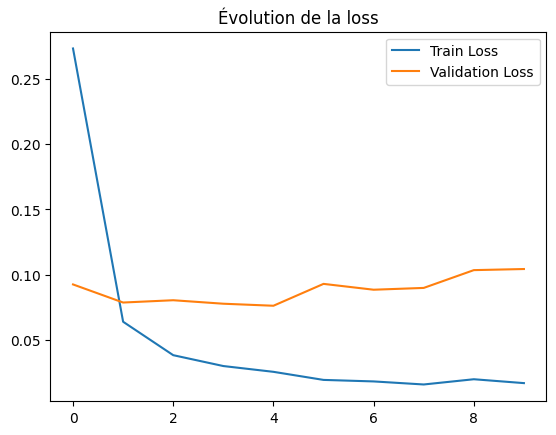

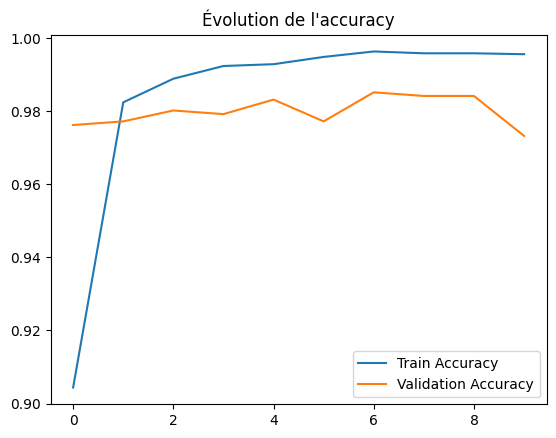

In [ ]:
# Visualisation de la perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Évolution de la loss')
plt.show()

# Visualisation de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Évolution de l\'accuracy')
plt.show()

In [ ]:
# Évaluation du modèle
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
print("Accuracy :", accuracy_score(y_test, y_pred))
print()
print('Classification report : ')
print(classification_report(y_test, y_pred))
print()
print('Matrice de confusion : ')
print(confusion_matrix(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
Accuracy : 0.9831181727904668

Classification report : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       876
           1       0.97      0.90      0.93       131

    accuracy                           0.98      1007
   macro avg       0.98      0.95      0.96      1007
weighted avg       0.98      0.98      0.98      1007


Matrice de confusion : 
[[872   4]
 [ 13 118]]
